In [3]:
import pandas as pd
import numpy as np

In [2]:
restricted_positions = {
    (442, 443), (443, 443), (442, 444), (443, 444),  # 곰자리 1
    (445, 443), (446, 443), (445, 444), (446, 444),  # 곰자리 2
}

In [4]:
num_people = 78  # 자리 개수 만큼 인원 생성
names = [f"Player{i+1}" for i in range(num_people)]
power = np.random.randint(1000, 10000, size=num_people)  # 전투력 (1000~10000 사이)
participation = np.random.rand(num_people)  # 참여율 (0~1 사이)

# 3. 참여율 로그 변환 및 KPI 계산
def transformed_participation(p):
    return np.log1p(p * 9)  # 참여율을 0~1 범위 내에서 로그 변환

df = pd.DataFrame({
    '이름': names,
    '전투력': power,
    '참여율': participation,
})

df['참여율 변환'] = df['참여율'].apply(transformed_participation)
df['KPI'] = df['전투력'] * df['참여율 변환']


In [5]:
df

,이름,전투력,참여율,참여율 변환,KPI
0,Player1,4395,0.245414,1.165875,5124.019425
1,Player2,2266,0.052236,0.385345,873.192491
2,Player3,1684,0.946305,2.253053,3794.140515
3,Player4,6474,0.626772,1.893254,12256.926743
4,Player5,1931,0.341513,1.404532,2712.151048
...,...,...,...,...,...
73,Player74,4174,0.091797,0.602223,2513.680789
74,Player75,3078,0.882415,2.190730,6743.066385
75,Player76,2341,0.978851,2.283368,5345.363696
76,Player77,9962,0.989422,2.293019,22843.057739


In [37]:
bear_positions = [(x, y) for x in range(442, 445) for y in range(443, 446)]

In [40]:
valid_seat_positions = []
assigned_positions = set()  # 이미 배정된 자리 저장

for x in range(430, 455):  # X축 범위
    for y in range(432, 460):  # Y축 범위
        square_seat = [(x, y), (x+1, y), (x, y+1), (x+1, y+1)]
        
        # 곰자리(노란색)와 직접 겹치지 않도록 수정
        if any(pos in bear_positions for pos in square_seat):
            continue  # 곰자리를 포함한 자리라면 스킵

        # 모든 자리(4칸)가 중복되지 않고, 배정 불가능한 자리가 포함되지 않아야 함
        if all(pos not in restricted_positions and pos not in assigned_positions for pos in square_seat):
            # 곰자리와의 거리 계산 (평균 거리)
            avg_distance = np.mean([min(np.linalg.norm(np.array(pos) - np.array(bear), 2) 
                                        for bear in bear_positions) for pos in square_seat])
            
            valid_seat_positions.append((avg_distance, square_seat))
            assigned_positions.update(square_seat) 

In [41]:
valid_seat_positions.sort(key=lambda x: x[0])

# 2. 배정 가능한 자리 수에 맞게 데이터프레임 생성
df_top = df.iloc[:len(valid_seat_positions)].copy()  # 배정 가능한 인원 수 맞추기
df_top['배정 좌표'] = None  # 배정 좌표 컬럼 추가

# 3. KPI 순으로 자리 배정 (곰자리와 가까운 자리부터 할당)
for i, (_, seat) in enumerate(valid_seat_positions[:len(df_top)]):
    df_top.at[i, '배정 좌표'] = seat

In [27]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rc
import platform
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else: #linux
    rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

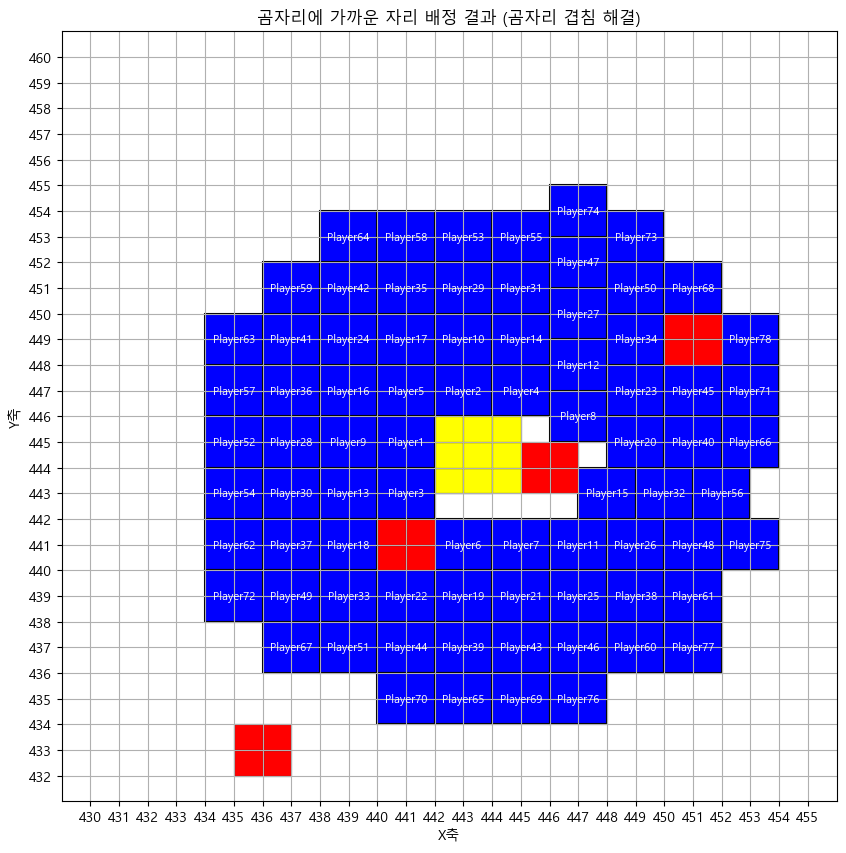

In [42]:
for i, (_, seat) in enumerate(valid_seat_positions[:len(df_top)]):
    df_top.at[i, '배정 좌표'] = seat

# 4. 최종 배정 결과 시각화 (외곽선 유지 & 곰자리 겹침 해결)
fig, ax = plt.subplots(figsize=(10, 10))

# 전체 영역 그리드 (흰색 배경)
for x in range(430, 456):
    for y in range(432, 461):
        ax.add_patch(plt.Rectangle((x, y), 1, 1, edgecolor='gray', facecolor='white', lw=0.5))

# 배정된 좌석 (파란색) 및 외곽선 표시
for idx, row in df_top.iterrows():
    seat_coords = row['배정 좌표']
    name = row['이름']
    
    # 2x2 영역을 파란색으로 칠하기
    for (x, y) in seat_coords:
        ax.add_patch(plt.Rectangle((x, y), 1, 1, facecolor='blue', lw=0))  # 내부 선 제거
    
    # 외곽선만 유지
    x_min = min(pos[0] for pos in seat_coords)
    x_max = max(pos[0] for pos in seat_coords) + 1
    y_min = min(pos[1] for pos in seat_coords)
    y_max = max(pos[1] for pos in seat_coords) + 1
    ax.add_patch(plt.Rectangle((x_min, y_min), 2, 2, edgecolor='black', facecolor='none', lw=1.5))

    # 2x2 중앙 위치 계산 후 텍스트 추가
    center_x = np.mean([pos[0] for pos in seat_coords])
    center_y = np.mean([pos[1] for pos in seat_coords])
    ax.text(center_x + 0.5, center_y + 0.5, name, fontsize=8, ha='center', va='center', color='white')

# 배정 불가능한 좌석 (빨간색)
for (x, y) in restricted_positions:
    ax.add_patch(plt.Rectangle((x, y), 1, 1, edgecolor='black', facecolor='red', lw=0.8))

# 곰자리 강조 (노란색)
for (x, y) in bear_positions:
    ax.add_patch(plt.Rectangle((x, y), 1, 1, edgecolor='black', facecolor='yellow', lw=0.8))

# 축 설정
ax.set_xlim(429, 456)
ax.set_ylim(431, 461)
ax.set_xticks(range(430, 456))
ax.set_yticks(range(432, 461))
ax.set_xlabel("X축")
ax.set_ylabel("Y축")
ax.set_title("곰자리에 가까운 자리 배정 결과 (곰자리 겹침 해결)")

plt.grid(True)
plt.show()